# Testing an Logistic Regression Model for Classification into Civic or Non-Civic Issues

## Importing the libraries and dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import os
import string
import nltk
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv("finalData.csv")
dataset = dataset[['description','civic_issue']]
dataset.drop_duplicates(subset='description',inplace=True, keep=False)
dataset.count()

description    30118
civic_issue    30118
dtype: int64

 ## Preprocessing the Description 
 
 The preprocessing is done in 4 steps:

    - removing punctuation
    - removing stopwords like 'the', 'this','as',etc
    - conversion of the entire text to lower case
    - Stemming: reducing the number of inflectional forms of words by reducing all to their common stem.
    
    For example, 'argue','arguing','argued' are all reduced to 'argu'

In [3]:
def preprocess():
    stemmer = PorterStemmer()
    words = stopwords.words("english")
    dataset['processedtext'] = dataset['description'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

preprocess()

In [4]:
dataset.head()

,description,civic_issue,processedtext
0,Garbage behind the temple,1,garbag behind templ
2,Air pollution in hebbal,1,air pollut hebbal
3,Garbage is dumped near BES,1,garbag dump near be
4,Leaf and garbage burning on Shakthi Ganapathi ...,1,leaf garbag burn shakthi ganapathi templ premi...
5,There is a lot of garbage dump in and around t...,1,there lot garbag dump around area lot small pe...


Splitting the dataset into train and test set

In [5]:
data = dataset[['processedtext','civic_issue']]
X_train, X_test, y_train, y_test = train_test_split(data['processedtext'],data['civic_issue'], test_size=0.20, random_state=42)

## Transforming the text into vectors

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

def vectorize(X_train, X_test):
    tfidf = TfidfVectorizer(stop_words='english')
    train_tfidf = tfidf.fit_transform(X_train.values.astype('U'))
    test_tfidf = tfidf.transform(X_test.values.astype('U'))
    return (train_tfidf, test_tfidf)

train_tfidf, test_tfidf = vectorize(X_train,X_test)

## Creating a Baseline model for comparison - Logistic Regression

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

def auc_roc(classifier):
    pred_probs = classifier.predict_proba(test_tfidf)
    train_probs = classifier.predict_proba(train_tfidf)[:,1]
    noSkillProb = [0 for _ in range(len(y_test))]
    lr_probs = pred_probs[:,1]

    noSkillAUC = roc_auc_score(y_test,noSkillProb)
    logRegAUC = roc_auc_score(y_test,lr_probs)

    print('No Skill: ROC AUC=%.3f' % (noSkillAUC))
    print('Logistic: ROC AUC=%.3f' % (logRegAUC))

    #FPR,TPR,thresholds = roc_curve(y_test,)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, noSkillProb)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    t_fpr,t_tpr,_ = roc_curve(y_train,train_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.plot(t_fpr,t_tpr,marker='*',label='Training')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [8]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, accuracy_score

def model_metrics(classifier,y_test,pred,score):
    print("R^2:", score*100, "%")
    print("Accuracy:", accuracy_score(y_test,pred)*100,"%")
    print("Precision:",precision_score(y_test,pred)*100,"%")
    print("Recall:",recall_score(y_test,pred)*100,"%")
    print("F1 Score:",f1_score(y_test,pred)*100,"%")
    print("MSE:",mean_squared_error(y_test,pred)*100,"%")
    print("Explained Variance Regression Score:", explained_variance_score(y_test,pred))
    auc_roc(classifier)

R^2: 97.17795484727756 %
Accuracy: 97.17795484727756 %
Precision: 98.65591397849462 %
Recall: 95.75994781474233 %
F1 Score: 97.18636213174446 %
MSE: 2.8220451527224433 %
Explained Variance Regression Score: 0.8879750294071336
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.996


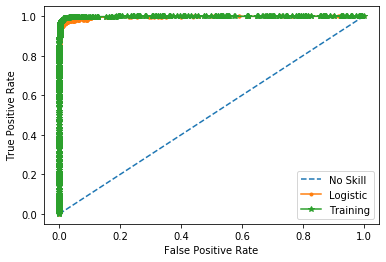

In [17]:
from sklearn.linear_model import LogisticRegression

def logReg(train_tfidf, test_tfidf,_C=1.0):
    classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.00001, verbose=0,
                   warm_start=False)
    classifier.fit(train_tfidf,y_train)
    score = classifier.score(test_tfidf,y_test)
    predictions = classifier.predict(test_tfidf)
    model_metrics(classifier,y_test,predictions,score)

logReg(train_tfidf,test_tfidf)

### Tuning the Hyperparameters for Logistic Regression

In [10]:
from sklearn.model_selection import GridSearchCV
import pickle

param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
tfidf_search = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search.fit(train_tfidf,y_train)
print(tfidf_search.get_params())
filename = 'logRegclassifier.sav'
pickle.dump(tfidf_search,open(filename,'wb'))


# for i in param_grid_['C']
# logReg(param_grid_['C'])

{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'iid': 'deprecated', 'n_jobs': None, 'param_grid': {'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 've

Train accuracy:  99.59325973271353 %


R^2: 97.4933598937583 %
Accuracy: 97.4933598937583 %
Precision: 98.47023611572996 %
Recall: 96.57534246575342 %
F1 Score: 97.51358471924912 %
MSE: 2.5066401062417 %
Explained Variance Regression Score: 0.9000859830627259
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.997


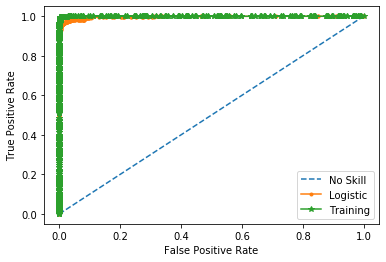

In [12]:
#sorted(tfidf_search.cv_results_.keys())

filename = 'logRegclassifier.sav'
pickle.load(open(filename, 'rb'))
pred_tuned = tfidf_search.predict(test_tfidf)
train_tuned = tfidf_search.score(train_tfidf, y_train)
print("Train accuracy: ", train_tuned*100, "%\n\n")
score_tuned = tfidf_search.score(test_tfidf,y_test)

model_metrics(tfidf_search,y_test,pred_tuned,score_tuned)

### Using K-Fold Cross Validation to test Performance Metrics

In [18]:
dataset.head()
X = np.array(dataset[['processedtext']]).reshape((len(dataset),))
y = dataset[['civic_issue']]

tfidf = TfidfVectorizer(stop_words='english')#,max_df=0.7)
Xtf = tfidf.fit_transform(X)



In [19]:
# Importing the KFold class from sklearn
from sklearn.model_selection import KFold, cross_val_score


def kfold_cross_validate():
    kfold = KFold(n_splits=10,shuffle=True)
    LR = LogisticRegression()
    scores = cross_val_score(LR,Xtf,y,cv=kfold, scoring='accuracy', n_jobs=-1)
    mean_acc = np.mean(scores)*100
    std_acc = np.std(scores)*100
    print("Mean Accuracy: %0.2f"%mean_acc, "%")
    print("Standard Deviation of Accuracy: %0.2f"%std_acc,"%")
kfold_cross_validate()

Mean Accuracy: 97.34 %
Standard Deviation of Accuracy: 0.29 %


## Building an ANN to compare metrics

https://realpython.com/python-keras-text-classification/


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import metrics

input_dim = train_tfidf.shape[1] # No. of features
print(input_dim)

model = Sequential()
model.add(layers.Dense(10,input_dim = input_dim, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


22714


In [47]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',metrics.Precision(name='precision'),metrics.Recall(name='recall'),metrics.RootMeanSquaredError(name='rmse')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                227150    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 227,161
Trainable params: 227,161
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(train_tfidf,y_train,epochs=100,verbose=False,validation_data=(test_tfidf,y_test),batch_size=10)

InvalidArgumentError:  TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 241, in __call__
    return func(device, token, args)

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 130, in __call__
    ret = self._func(*args)

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 309, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 513, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 513, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 512, in slice_array
    contiguous=contiguous)

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_utils.py", line 391, in slice_arrays
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_utils.py", line 391, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "C:\Users\Adithi Satish\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_utils.py", line 391, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

TypeError: 'SparseTensor' object is not subscriptable


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1689]

Function call stack:
train_function
